In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../Environment/Version3')
from rl_mh import RLMHEnv
from mcmctoolbox.functoolbox import flat

from tqdm.auto import trange

import toml
from types import SimpleNamespace

import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

config = toml.load("./rlmcmc/config/ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

import logging
logging.basicConfig(filename="DDPG_single.log", level=logging.INFO)

# Log to Tensorboard
from torch.utils.tensorboard import SummaryWriter
import time

writer = SummaryWriter(f"runs/V3/{str(time.time())}")

In [2]:
# Initialize Agent

class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(32)(x)
        x = nn.softplus(x)
        x = nn.Dense(16)(x)
        x = nn.softplus(x)
        x = nn.Dense(8)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        return x

In [3]:
class Actor(nn.Module):
    sample_dim: int

    @nn.compact
    def __call__(self, obs: jnp.ndarray):
        """
        Mu function
        """
        x, mcmc_noise = jnp.split(obs, [self.sample_dim], axis=1)
        x_star = self.gene_x_star(x, mcmc_noise)

        cov_x_flatten = self.cov(x).reshape(-1, 2*self.sample_dim)
        cov_x_star_flatten = self.cov(x_star).reshape(-1, 2*self.sample_dim)

        return jnp.hstack([cov_x_flatten, x_star, cov_x_star_flatten])

    def low_rank_vect_and_mag(self, x):
        x = nn.Dense(32)(x)
        x = nn.softplus(x)
        x = nn.Dense(16)(x)
        x = nn.softplus(x)
        x = nn.Dense(8)(x)
        x = nn.softplus(x)
        x = nn.Dense(self.sample_dim+1, use_bias=True)(x)
        return x

    def cov(self, x):
        low_rank_vec, mag = jnp.split(
            self.low_rank_vect_and_mag(x), [self.sample_dim], axis=1
        )

        return (
            low_rank_vec[:, :, None] * low_rank_vec[:, None, :]
            + mag[:, :, None]**2 * jnp.eye(self.sample_dim )[None, :, :]
        )  # Outer Product

    def gene_x_star(self, x, mcmc_noise):
        cov_x = self.cov(x)
        cov_x_sqrt = jax.lax.fori_loop(0, cov_x.shape[0], self.cholesky_decompose, cov_x)
        return (
            x
            + jnp.matmul(cov_x_sqrt, mcmc_noise[:, :, None]).squeeze()
        )

    def cholesky_decompose(self, i, matrices):
        updated_matrix = jnp.linalg.cholesky(matrices[i])
        return matrices.at[i].set(updated_matrix)

In [4]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [5]:
# Load DataBase Locally
pdb_path = "/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Python/posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-SimpleEggBox-test-SimpleEggBox")
stan_code = posterior.model.stan_code_file_path()
# stan_data = json.dumps(posterior.data.values())
stan_data = json.dumps({"sigma": 1, "r": 20})
model = bs.StanModel.from_stan_file(stan_code, stan_data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density


In [6]:
# Setup env
sample_dim = 2
action_dim = 2 * sample_dim**2 + sample_dim
state_dim = sample_dim * 2

total_timesteps=100_000
args.total_timesteps = total_timesteps
args.batch_size = 32

env = RLMHEnv(
    log_target_pdf=log_p,
    sample_dim=sample_dim,
    total_timesteps=total_timesteps
    )
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False
)

In [7]:
# Start
obs, _ = env.reset(seed=args.seed)
actor = Actor(sample_dim=sample_dim)
qf1 = QNetwork()

In [8]:
args.learning_rate = 1e-4

In [9]:
actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
) # theta

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    params=qf1.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf1.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
) # q

actor.apply = jax.jit(actor.apply)
qf1.apply = jax.jit(qf1.apply)

In [10]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    # next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)
    next_state_actions = (actor.apply(actor_state.target_params, next_observations))
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    logging.info("update_critic grads:", grads)

    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)

    logging.info("update_actor grads:", grads)

    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value

In [11]:
for global_step in trange(args.total_timesteps):
    actions = actor.apply(actor_state.params, obs)

    writer.add_scalars('mcmc/trace_plot', {'x': obs[:, 0].item(), 'y': obs[:, 1].item()}, global_step)

    # actions = (np.array(actions) + np.random.normal(0, args.exploration_noise)).clip(
    #                 env.action_space.low, env.action_space.high
    #             )

    next_obs, rewards, terminateds, truncateds, infos = env.step(np.array(actions, dtype=np.float64))
    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state=actor_state,
            qf1_state=qf1_state,
            observations=data.observations.reshape(-1, state_dim).numpy(),
            actions=data.actions.numpy(),
            next_observations=data.next_observations.reshape(-1, state_dim).numpy(),
            rewards=data.rewards.flatten().numpy(),
            dones=data.dones.flatten().numpy()
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state=actor_state,
                qf1_state=qf1_state,
                observations=data.observations.reshape(-1, state_dim).numpy(),
            )

        if global_step > args.policy_frequency:
            writer.add_scalar("losses/qf1_loss", qf1_loss_value.item(), global_step)
            writer.add_scalar("losses/qf1_values", qf1_a_values.item(), global_step)
            writer.add_scalar("losses/actor_loss", actor_loss_value.item(), global_step)
            writer.add_scalar("rewards/rewards", rewards.item(), global_step)

  0%|          | 0/100000 [00:00<?, ?it/s]

/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Jax/../Environment/Version3/rl_mh.py:47: RuntimeWarning: invalid value encountered in log
  return (-0.5 * len(mean) * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(cov)) - 0.5 * (x - mean) @ np.linalg.inv(cov) @ (x - mean).T).squeeze()


In [12]:
state_list = np.array([i for i in env.store_state]).reshape(-1, state_dim)
action_list = np.array([i for i in env.store_action]).reshape(-1, action_dim)

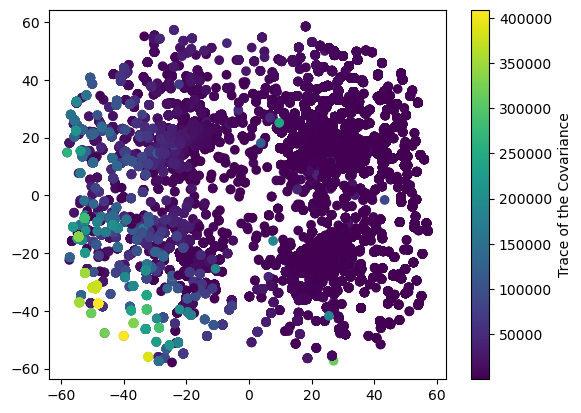

In [13]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
sc = ax.scatter(state_list[1:, 0], state_list[1:, 1], c=(action_list[:, 0] + action_list[:, 3]), cmap='viridis')

plt.colorbar(sc, label='Trace of the Covariance')

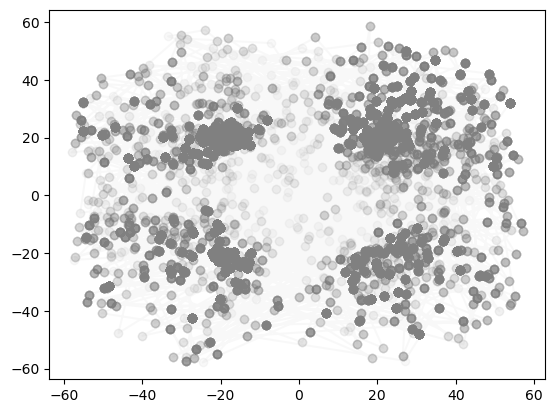

In [14]:
plt.plot(state_list[1:, 0], state_list[1:, 1], 'o-', color='grey', alpha=0.05)

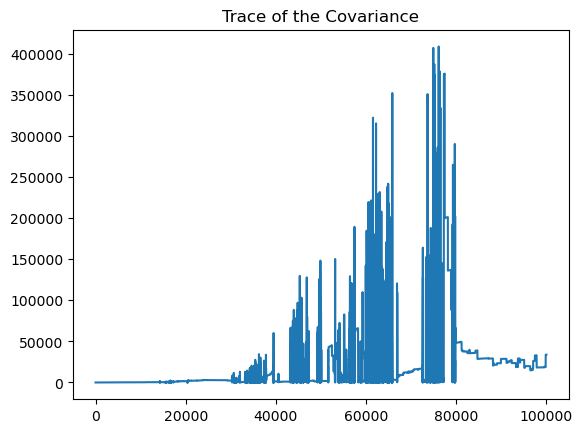

In [15]:
plt.plot(action_list[:, 0] + action_list[:, 3])
plt.title("Trace of the Covariance")
plt.show()

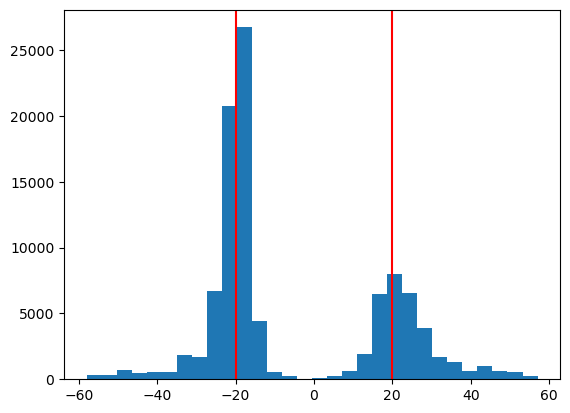

In [16]:
plt.hist(state_list[:, 0], bins=30)
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


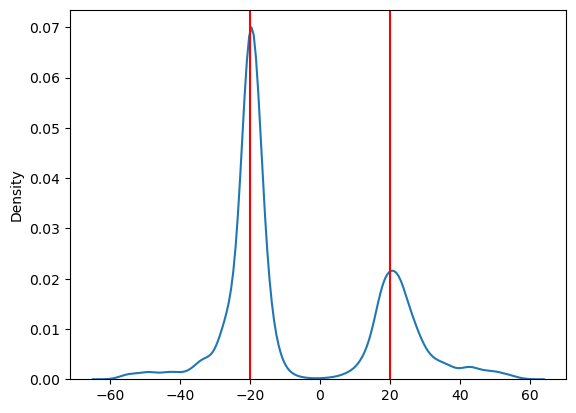

In [17]:
import seaborn as sns

sns.kdeplot(state_list[:, 0])
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

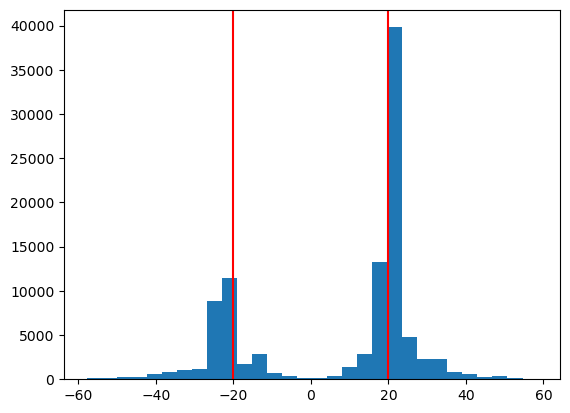

In [18]:
plt.hist(state_list[:, 1], bins=30)
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


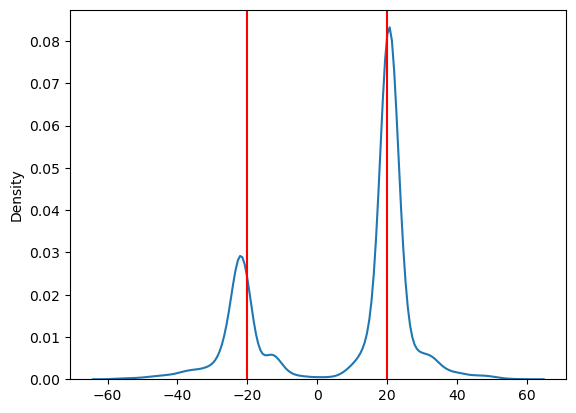

In [19]:
sns.kdeplot(state_list[:, 1])
plt.axvline(-20, color="red")
plt.axvline(20, color="red")
plt.show()

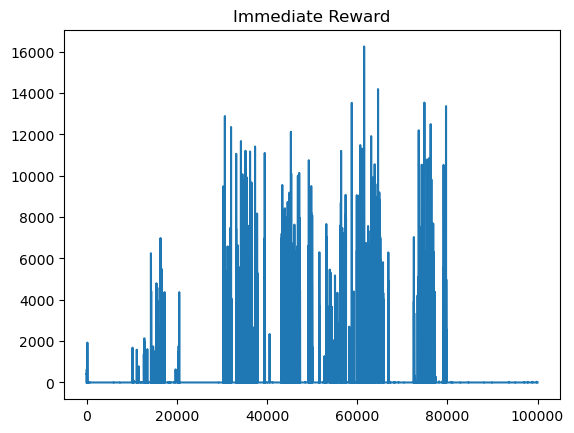

In [40]:
plt.plot(env.store_reward)
plt.title("Immediate Reward")
plt.show()

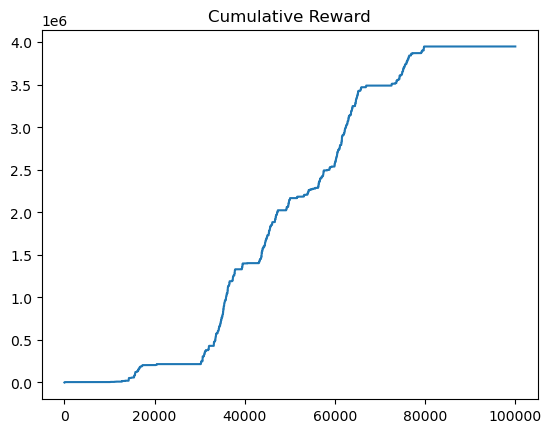

In [21]:
plt.plot(np.cumsum(env.store_reward))
plt.title("Cumulative Reward")
plt.show()

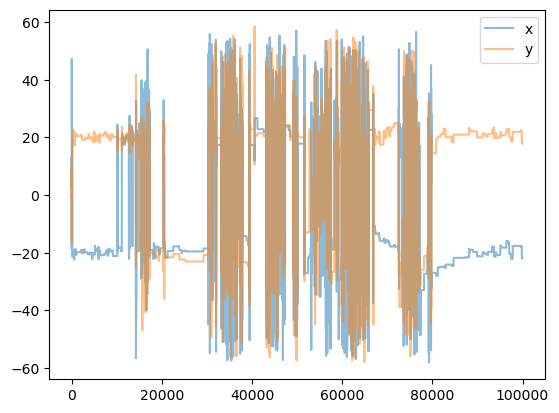

In [22]:
plt.plot(state_list[:, 0], label="x", alpha=0.5)
plt.plot(state_list[:, 1], label="y", alpha=0.5)
plt.legend()
plt.show()

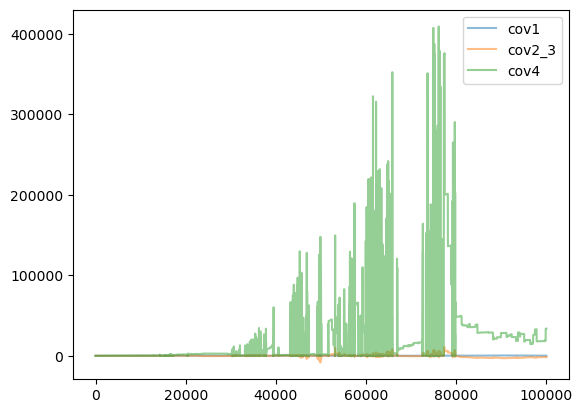

In [23]:
plt.plot(action_list[:, 0], label="cov1", alpha=0.5)
plt.plot(action_list[:, 1], label="cov2_3", alpha=0.5)
plt.plot(action_list[:, 3], label="cov4", alpha=0.5)
plt.legend()
plt.show()

In [24]:
np.sum(env.store_accetped_status)/len(env.store_accetped_status)

0.01785982140178598

In [46]:
import pandas as pd
df = pd.DataFrame(
    np.hstack(
        [
    state_list[1:, 0:2],
    action_list[:, 0:4],
    np.array(env.store_reward).reshape(-1, 1)[1:],
    np.array(env.store_log_accetance_rate).reshape(-1, 1)[1:],
    np.array(env.store_accetped_status).reshape(-1, 1)[1:]
        ]
    ),
    columns=['x', 'y', 'cov1', 'cov2', 'cov3', 'cov4', 'rewards', 'log_alpha', 'accepted_status']
)
# Find the row with the largest value in the 'rewards' column
max_rewards_row = df.loc[
    [
        df['rewards'].idxmax() - 2,
        df['rewards'].idxmax() - 1,
        df['rewards'].idxmax(),
        df['rewards'].idxmax() + 1,
        df['rewards'].idxmax() + 2
    ]
]

max_rewards_row

,x,y,cov1,cov2,cov3,cov4,rewards,log_alpha,accepted_status
61533,51.429787,34.458160,29.408215,212.226410,212.226410,1623.080811,0.000000,-inf,0.0
61534,51.429787,34.458160,29.408215,212.226410,212.226410,1623.080811,0.000000,-inf,0.0
61535,-46.075066,-47.677597,29.408215,212.226410,212.226410,1623.080811,16253.478872,0.0,1.0
61536,-46.075066,-47.677597,34.053318,3285.856689,3285.856689,322314.843750,0.000000,-inf,0.0
61537,-31.185099,37.660637,34.053318,3285.856689,3285.856689,322314.843750,7504.325290,0.0,1.0


In [26]:
(df["cov2"] == df["cov3"]).value_counts()
df["cov2"].apply(lambda x: 'GE0' if x >= 0 else 'L0').value_counts()
df["cov2"].min()

-8298.0322265625

In [37]:
from sklearn.ensemble import IsolationForest

clf_reward = IsolationForest(n_estimators=100, contamination=10/total_timesteps, random_state=1234)
clf_reward.fit(df['rewards'].to_numpy().reshape(-1, 1))
pred_reward = clf_reward.predict(df['rewards'].to_numpy().reshape(-1, 1))
df['anomaly_reward'] = pred_reward
outliers_reward = df[df['anomaly_reward'] == -1]
outliers_reward

,x,y,cov1,cov2,cov3,cov4,rewards,accepted_status,anomaly_reward,anomaly_actions
30657,-54.743423,-12.988911,5.087410,23.277815,23.277815,111.468315,12887.373891,1.0,-1,1
32023,-54.345272,-14.717922,4.933766,27.338957,27.338957,153.008240,12357.976229,1.0,-1,1
45300,42.891960,18.537174,43.030781,-1685.941528,-1685.941528,129755.429688,12126.169237,1.0,-1,1
58797,53.484299,-29.504509,8.638140,-588.401184,-588.401184,40242.171875,13525.522200,1.0,-1,1
61535,-46.075066,-47.677597,29.408215,212.226410,212.226410,1623.080811,16253.478872,1.0,-1,1
64623,55.036804,-34.845139,10.545069,773.442322,773.442322,128594.734375,14191.219379,1.0,-1,1
73648,41.048492,34.085999,106.085754,5908.678223,5908.678223,329098.093750,12197.738488,1.0,-1,1
74905,-39.988739,-48.645687,11.356912,19.330854,19.330854,85.013229,13538.635323,1.0,-1,1
76296,-48.990765,-32.208427,13.118511,76.101982,76.101982,461.803253,12496.624881,1.0,-1,1
79701,-53.743008,15.375500,1.919868,17.268612,17.268612,515.640686,13368.491686,1.0,-1,1


In [38]:
clf_actions = IsolationForest(n_estimators=100, contamination=10/total_timesteps, random_state=1234)
clf_actions.fit(df[['cov1', 'cov2', 'cov3', 'cov4']])
pred_actions = clf_actions.predict(df[['cov1', 'cov2', 'cov3', 'cov4']])
df['anomaly_actions'] = pred_actions
outliers_actions = df[df['anomaly_actions'] == -1]
outliers_actions.drop('anomaly_reward', axis=1)

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


,x,y,cov1,cov2,cov3,cov4,rewards,accepted_status,anomaly_actions
